# Course : Video edit

## Winter semister 2021-22

##### Christina Seventikidou

##### Tutor: L. Kontis

# Project 3 - 40%

In [2]:
#imports
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image 
from numpy import r_
from scipy import fft
from scipy.fft import dct
import scipy
import math

from math import log10, sqrt
  

# PART 1 - FRAME 178

## Βήμα 1. φόρτωση αρχείων
Διαβάστε τα αρχεία που αντιστοιχούν στο Y component των frames 178 και 179 της εικονοσειράς “Foreman”.

In [3]:
frame178 = Image.open('frame178.jpg')
frame179 = Image.open('frame179.jpg')

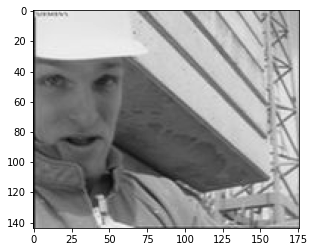

In [4]:
plt.imshow(frame178,cmap='gray')

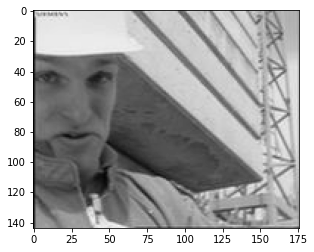

In [5]:
plt.imshow(frame179,cmap='gray')

In [6]:
frame178 = np.asarray(frame178)
frame179 = np.asarray(frame179)

#### Το frame 178 θα κωδικοποιηθεί ως I-frame ενώ το frame 179 θα κωδικοποιηθεί ως P-frame.

## frame178 coding

Θα κάνουμε intra prediction για το frame 178, δηλαδή κάνουμε πρόβλεψη από τα γειτονικά blocks του υπάρχοντος frame και όχι χρησιμοποιώντας άλλο frame. Συγκεκριμένα, η διαδικασία λέει: 
1. Χωρίστε το frame 178 σε μπλοκ μεγέθους 4 × 4.
2. Θεωρήστε τα τρία πρώτα intra prediction modes (horizontal, vertical, DC) της διαφάνειας 22 της διάλεξης 9.
3. Για καθε μπλοκ υπολογίστε την πρόβλεψη με κάθε mode και επιλέξτε αυτη που αντιστοιχεί στο ελάχιστο SAD. 
4. Αφαιρέστε την πρόβλεψη από το αυθεντικό μπλοκ(θα προκύψει το σφάλμα πρόβλεψης),
  - πάρτε τον DCT δύο διαστάσεων στο σφάλμα πρόβλεψης και
  - κβαντίστε όπως στο JPEG με βήμα κβάντισης 40 για όλους τους συντελεστές. Πόσοι κβαντισμένοι συντελεστές είναι μηδενικοί;
5. Για κάθε μπλοκ, εκτελέστε ‘αντίστροφη κβάντιση’, αντίστροφο DCT και προσθέστε την πρόβλεψη.
6. Ενώστε όλα τα μπλοκ και για να προκύψει το αναδημιουργημένο frame 178. Ποιο είναι το PSNR;

-------------------------------------------------------------------------------------------------------------------------------

- Αρχικά θα φτιάξουμε 3 συναρτήσεις υπεύθυνες για τα 3 intra prediction modes. Η κάθε μία δέχεται το frame και τους δείκτες i,j του τρέχοντος 4x4 block. Επειδή τα i,j θα παίρνουν τιμές 0,4,8,12,16 .. μπορούμε να έχουμε στη διάθεση μας το προηγούμενο 4χ4 block κάθετα και οριζόντια. Παρακάτω ακολουθεί επεξήγηση για το κάθε mode που εξηγεί την υλοποίηση των συναρτήσεων.

#### 1.  Vertical mode:  
Έστω ένα 4χ4 μπλοκ, βρίσκουμε το προηγούμενο 4χ4 μπλοκ που βρίσκεται ακριβώς από πάνω του και από αυτό ελέγχουμε μόνο την γραμμή 3(τελευταία γραμμή του μπλοκ). Τα στοιχεία (3,i) θα μεταφερθούν προς τα κάτω (vertical mode) και θα γεμίσουν ένα νέο 4χ4 μπλοκ(prediction). Ουσιαστικά όλη η πρώτη στήλη του νέου μπλοκ(prediction) θα έχει το στοιχείο (3,0), η δεύτερη το (3,1) κτλπ. Το νέο αυτό μπλοκ είναι η πρόβλεψη με vertical intra prediction mode.

#### 2. Horizontal mode:
Το ίδιο ακριβώς γίνεται οριζόντια. Έστω ένα 4χ4 μπλοκ. Βρίσκουμε το προηγούμενο 4χ4 μπλοκ απο τα αριστερά και κρατάμε την τελευταία του στήλη (i,3). Τα στοιχεία αυτά μεταφέρονται οριζόντια και γεμίζουν ένα νέο 4χ4 μπλοκ το οποίο είναι η πρόβλεψη με horizontal intra prediction mode.

#### 3. DC mode:
Έστω ένα 4χ4 μπλοκ. Εδώ χρειαζόμαστε το προηγούμενο 4χ4 μπλοκ απο πάνω αλλά και το προηγούμενο μπλοκ 4χ4 από τα αριστερά. Παίρνουμε την τελευταία γραμμή και από τα δύο προηγούμενα μπλοκ και τις αθροίζουμε. Παίρνουμε το μέσο όρο(διαιρούμε με το 8) και γεμίζουμε ένα νεό 4χ4 μπλοκ με αυτή την τιμή. Αυτό το νέο μπλοκ είναι η πρόβλεψη με dc intra prediction mode.

#### Υπολογισμός του SAD, sum of absolute differences:
είναι ένα μέτρο ομοιότητας μεταξύ δύο μπλοκ. Θα το υπολογίσουμε εδώ παίρνοντας την απόλυτη διαφορά μεταξύ κάθε πίξελ του original και του prediction μπλοκ. Αυτές οι διαφορές αθροίζονται και δημιουργούν έτσι μία μετρική ομοιότητας block, την L1 νόρμα της διαφοράς τους. Αυτή η διαφορά λέγεται difference ή residual. Οπότε έχουμε $$ \| difference \|$$ . Θα υπολογίσουμε το prediction με τα τρία διαφορετικά modes και θα επιλέξουμε το mode με τη μικρότερη νόρμα( μικρότερο SAD).

#### κβάντιση όπως στο jpeg με βήμα κβάντισης 40. 
Θα χρησιμοποιήσουμε τον τύπο $$qdct=floor((dctblock+QM/2)./(QM)) $$ , όπου το QM για εμάς είναι 40 για όλους τους συντελεστές(βήμα κβάντισης). Όταν θα κβαντίσουμε κάποιοι συντελεστές θα γίνουν 0. Πόσοι? 


###### ερώτημα 3:

#### " αντίστροφη κβάντιση"
Έπειτα θα κάνουμε την αντίστροφη διαδικασία για να πάρουμε πίσω το αρχικό μπλοκ("αντίστροφη κβάντιση"). Κατά την κβάντιση έχουμε χάσει πληροφορία οπότε στην πραγματικότητα η διαδικασία δεν αντιστρέφεται. Αυτό που θα κάνουμε είναι να χρησιμοποιήσουμε τον τύπο $$  iqdct=qdct.*QM $$ . Έπειτα ενώνουμε όλα τα μπλοκ της εικόνας και θα προκύψει το νέο frame178. Δε θα ταυτίζεται ακριβώς με το αρχικό καθώς έχει γίνει κβάντιση. Με το PSNR θα πάρουμε μία ένδειξη για το πόσο καλή είναι η ποιότητα της εικόνας.

In [7]:
#functions used 

In [8]:
def idct2(a):
    return scipy.fft.idct( scipy.fft.idct( a, axis=0 , norm='ortho'), axis=1 , norm='ortho')

In [9]:
def dct2(a):
    return scipy.fft.dct( scipy.fft.dct( a, axis=0, norm='ortho' ), axis=1, norm='ortho' )

In [10]:
def vertical_mode(frame,i,j):
    previous_block = frame[i-4:i,j:j+4]
    v_block = np.zeros((4,4))
    
    for i in range(0,4):
        v_block[0:4,i] = int(previous_block[3,i])
    return v_block

In [11]:
def horizontal_mode(frame,i,j):
    previous_block = frame[i:i+4,j-4:j]
    h_block = np.zeros((4,4))

    for i in range(0,4):
        h_block[i,0:4] = int(previous_block[i,3])
    return h_block

In [12]:
def dc_mode(frame,i,j):
    previous_block_vertical = frame[i-4:i,j:j+4]
    previous_block_horizontal = frame[i:i+4,j-4:j]
    sum_vert=0
    sum_hor=0
    for i in range(0,4):
        sum_vert = sum_vert + int(previous_block_vertical[3,i])
        sum_hor = sum_hor + int(previous_block_horizontal[i,3])
    mean = (sum_vert+sum_hor)/8
    dc_block = np.ones((4,4))*mean
    dc_block =dc_block.astype(int)
    
    return dc_block

In [13]:
#code for the implemantation

In [14]:
imsize = frame178.shape
new_frame_178 = np.zeros(imsize)
zero_coef =0

for i in r_[:imsize[0]:4]:
    for j in r_[:imsize[1]:4]:
        block = frame178[i:(i+4),j:(j+4)]
        new_frame_178[i:(i+4),j:(j+4)] = block
        if (i != 0 and j !=0) :
            pred_block_vertical = vertical_mode(new_frame_178,i,j)
            pred_block_horizontal = horizontal_mode(new_frame_178,i,j)
            pred_block_dc = dc_mode(frame178,i,j)
        
            sad_vert = np.sum(np.abs(block - pred_block_vertical))
            sad_hor = np.sum(np.abs(block - pred_block_horizontal))
            sad_dc = np.sum(np.abs(block - pred_block_dc))
        
            sads=(sad_vert, sad_hor, sad_dc)
            index_min = np.argmin(sads) # position of min_sad in sads
            min_sad = min(sad_vert, sad_hor, sad_dc) #min_sad
            if (index_min == 0):
                min_mode_block = pred_block_vertical
            elif (index_min == 1):
                min_mode_block = pred_block_horizontal
            else:
                min_mode_block = pred_block_dc

            dif_block = block - min_mode_block
            dif_block = dct2(dif_block)
            qdct  = np.floor((dif_block + (40/2))/40)
            result = np.where(qdct==0)
            n_zeros = result[0].size
            zero_coef = zero_coef + n_zeros
        
            iqdct = qdct * 40
            iqdct = idct2(iqdct)
            dif_block = iqdct + min_mode_block
            new_frame_178[i:(i+4),j:(j+4)] = dif_block

 The number of zero coefficients is: 21424


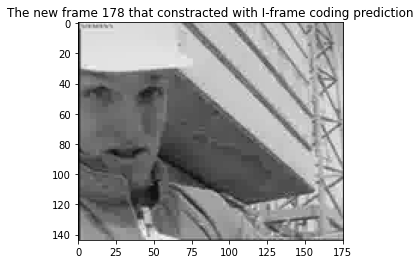

In [15]:
plt.figure()
plt.imshow(new_frame_178,cmap='gray')
plt.title("The new frame 178 that constracted with I-frame coding prediction")
print(f" The number of zero coefficients is: {zero_coef}") 

In [16]:
def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

In [17]:
PSNR(frame178, new_frame_178)

31.87215834162549

# PART 2 - FRAME 179

## frame 179 coding 


1. Χωρίστε το frame179 σε macroblocks μεγέθους 4 × 4 και 
2. εκτελέστε εκτίμηση κίνησης μεταξύ του frame179 και του αναδημιουργημένου frame 178, έτσι ώστε να βρείτε ένα διάνυσμα κίνησης ανά macroblock.
- Θεωρήστε ότι τα διανύσματα κίνησης (x, y) μπορούν να πάρουν ακέραιες τιμές x ∈ [−8, 8] και y ∈ [−8, 8].
- Χρησιμοποιήστε τις εξής τρεις μεθόδους εκτίμησης κίνησης: 
   1. Τη μέθοδο exhaustive search
   2. τη γρήγορη μέθοδο “2-DLog Search” με αρχικο βήμα 4
   3. τη γρήγορη μέθοδο “Three-Step Search” με αρχικο βήμα 4. 
3. Χρησιμοποιήστε το κριτήριο SAD για την εύρεση των διανυσμάτων κίνησης.
- Αγνοήστε υποψήφια διανύσματα κίνησης τα οποία θα οδηγούσαν σε μπλοκ που βγαίνει έξω από το frame 178. Μετρήστε πόσοι υπολογισμοί του SAD χρειάστηκαν για καθεμία από τις τρεις μεθόδους;
4. για κάθε μπλοκ 4 × 4 του frame179 βρείτε τη βέλτιστη intra πρόβλεψη όπως στο frame178 και επιλέξτε μεταξύ intra και inter πρόβλεψης με κριτήριο το SAD. Σε πόσα μπλοκ επιλέχθηκε intra mode;


έπειτα,
5. Αφαιρέστε την πρόβλεψη από το αυθεντικό μπλοκ
   - πάρτε τον DCT δύο διαστάσεων στο σφάλμα πρόβλεψης 
   - και κβαντίστε όπως στο JPEG με βήμα κβάντισης 40 για όλους τους συντελεστές. Πόσοι κβαντισμένοι συντελεστές είναι μηδενικοί;
6. Για κάθε μπλοκ, εκτελέστε ‘αντίστροφη κβάντιση’, αντίστροφο DCT και προσθέστε την πρόβλεψη.
7. Ενώστε όλα τα μπλοκ και για να προκύψει το αναδημιουργημένο frame 179. Ποιο είναι το PSNR; 
   - Τα δύο τελευταία βήματα θα πρέπει να γίνουν τρεις φορές, μία για κάθε μέθοδο εκτίμησης κίνησης.

In [23]:
#Exhaustive search, we test 17^2 motion vectors(blocks) and we search this one with the mininum sad
#block of image: a block of frame 179, previous prediction is the new frame 178 from part 1
def exhaustive_search(block_of_image, previous_prediction, i, j): 
    d1, d2 = previous_prediction.shape
    n_sad =0
    min_sad = math.inf
    for x in range(-8,9):
        for y in range(-8,9):
            x_point = i+x
            y_point = j+y
            point = (x_point, y_point)
            
            if (((x_point>0) and (y_point>0)) and ((x_point + 4)<=d1 ) and ((y_point +4)<=d2)):
                pred_block = previous_prediction[point[0]:point[0]+4, point[1]:point[1]+4]
                sad = np.sum(np.abs(block_of_image - pred_block))
                n_sad = n_sad +1
                if (sad<min_sad):
                    min_sad = sad
                    pred_min_block = pred_block
    return  min_sad, pred_min_block,n_sad

In [24]:
def dlog_search(block_of_image, previous_prediction, step, i, j):
    n_sad =0
    d1, d2 = previous_prediction.shape
    center_point =(i,j) #px (0,4)
    min_sad =math.inf
    points_array =[]
    sads_array=[]
    points=[]
    while(step !=0):
        
        for x in range(-step,step+1, step): # px -2,0,2
            for y in range(-step,step+1, step): # -2,0,2
                xi_point = x+i #0
                yi_point = j #4
                xj_point = i #0
                yj_point = j +y # 2
                i_points = (xi_point, yi_point) #(-2,4), (2,4)
                j_points =(xj_point, yj_point) #(0,2), (0,4), (0,6)
                if (i_points not in points):
                    points.append(i_points)
                if (j_points not in points):
                    points.append(j_points) #points keep the five points
        for point in points:
                if (((point[0]>0) and (point[1]>0)) and ((point[0] + 4)<=d1 ) and ((point[1] +4)<=d2)):
                    if point in points_array:
                        index = points_array.index(point)
                        sad = sads_array[index]
                    else:
                        pred_block = previous_prediction[point[0]:point[0]+4, point[1]:point[1]+4]
                        sad = np.sum(np.abs(block_of_image - pred_block))
                        points_array.append(point)
                        sads_array.append(sad)
                        
                    n_sad = n_sad +1
                    if (sad<min_sad):
                        min_sad = sad
                        pred_min_block = pred_block
                        min_point = point
        
        
        if ((min_point == center_point) or (min_point[0] == -8 or min_point[0] == 8) or (min_point[1] == -8 or min_point[1] == 8)):
                step = int(step/2)
         
        center_point = min_point
        i=center_point[0]
        j=center_point[1]
        
        if (step == 1):
            points = nine_points(step, i, j)
            for point in points:
                if (((point[0]>0) and (point[1]>0)) and ((point[0] + 4)<=d1 ) and ((point[1] +4)<=d2)):
                    if point in points_array:
                        index = points_array.index(point)
                        sad = sads_array[index]
                    else:
                        pred_block = previous_prediction[point[0]:point[0]+4, point[1]:point[1]+4]
                        sad = np.sum(np.abs(block_of_image - pred_block))
                        points_array.append(point)
                        sads_array.append(sad)
                    n_sad = n_sad +1
                    if (sad<min_sad):
                        min_sad = sad
                        pred_min_block = pred_block
                        min_point = point
    return min_sad, pred_min_block, n_sad

In [25]:
def nine_points(step,i,j):
    points=[]
    for x in range(i-step,i+step+1,step):
        for y in range(j-step,j+step+1,step):
            points.append((x,y))

    return points

In [26]:
def thr_step_search(block_of_image, previous_prediction,step, i,j):
    n_sad =0
    d1, d2 = previous_prediction.shape
    center_point =(i,j) #px (0,4)
    min_sad =math.inf
    points_array =[]
    sads_array=[]
    while (step!=0):
        points = nine_points(step,i,j)
        for point in points:
                if (((point[0]>0) and (point[1]>0)) and ((point[0] + 4)<=d1 ) and ((point[1] +4)<=d2)):
                    if point in points_array:
                        index = points_array.index(point)
                        sad = sads_array[index]
                    else:
                        pred_block = previous_prediction[point[0]:point[0]+4, point[1]:point[1]+4]
                        sad = np.sum(np.abs(block_of_image - pred_block))
                        points_array.append(point)
                        sads_array.append(sad)
                        
                    n_sad = n_sad +1
                    if (sad<min_sad):
                        min_sad = sad
                        pred_min_block = pred_block
                        min_point = point
        

        center_point = min_point
        i=center_point[0]
        j=center_point[1]
        
        step = int(step/2)
        
    return min_sad, pred_min_block, n_sad

In [27]:
# code for the implementation

# Exhaustive Search: 

In [30]:
imsize = frame179.shape
new_frame_179 = np.zeros(imsize)
zero_coef_179 =0
num_of_intra =0
sad_total =0
for i in r_[:imsize[0]:4]:
    for j in r_[:imsize[1]:4]:
        block = frame179[i:(i+4),j:(j+4)]
        new_frame_179[i:(i+4),j:(j+4)] = block
        if (i!=0 and j!=0) :
            sad_motion,pred_motion,n_sad = exhaustive_search(block,new_frame_178,i,j)
            sad_total = sad_total + n_sad
            pred_block_vertical = vertical_mode(new_frame_179,i,j)
            pred_block_horizontal = horizontal_mode(new_frame_179,i,j)
            pred_block_dc = dc_mode(new_frame_179,i,j)
            sad_vert = np.sum(np.abs(block - pred_block_vertical))
            
            sad_hor = np.sum(np.abs(block - pred_block_horizontal))
            sad_dc = np.sum(np.abs(block - pred_block_dc))
            sads= (sad_motion,sad_vert, sad_hor, sad_dc)
            blocks =(pred_motion,pred_block_vertical,pred_block_horizontal,pred_block_dc)
            
            index = np.argmin(sads) # position of min_sad in sads
            min_block = blocks[index]
            min_sad = sads[index]
            if (min_sad != sad_motion):
                num_of_intra = num_of_intra + 1
                
                
            dif_block = block - min_block
            dif_block = dct2(dif_block)
            qdct  = np.floor((dif_block + (40/2))/40)
            result = np.where(qdct==0)
            n_zeros = result[0].size
            zero_coef = zero_coef + n_zeros
        
            iqdct = qdct * 40
            iqdct = idct2(iqdct)
            new_frame_179[i:(i+4),j:(j+4)] = iqdct + min_block

In [31]:
print(f" Number of sad calculations is :{sad_total}") 
print(f" Number of zero coefficients is :{zero_coef}") 
print(f" Number of intra mode selection is :{num_of_intra}") 

 Number of sad calculations is :411401
 Number of zero coefficients is :44852
 Number of intra mode selection is :72


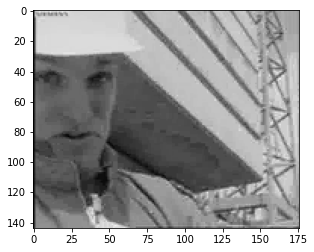

In [32]:
plt.figure()
plt.imshow(new_frame_179,cmap='gray')

In [33]:
PSNR(frame179, new_frame_179)

32.633357358085775

# 2dlog search:

In [34]:
imsize = frame179.shape
new_frame_179 = np.zeros(imsize)
zero_coef_179 =0
num_of_intra =0
sad_total =0
for i in r_[:imsize[0]:4]:
    for j in r_[:imsize[1]:4]:
        block = frame179[i:(i+4),j:(j+4)]
        new_frame_179[i:(i+4),j:(j+4)] = block
        if (i!=0 and j!=0) :
            sad_motion,pred_motion,n_sad = dlog_search(block,new_frame_178,4,i,j)
            sad_total = sad_total + n_sad
            pred_block_vertical = vertical_mode(new_frame_179,i,j)
            pred_block_horizontal = horizontal_mode(new_frame_179,i,j)
            pred_block_dc = dc_mode(new_frame_179,i,j)
            sad_vert = np.sum(np.abs(block - pred_block_vertical))
            
            sad_hor = np.sum(np.abs(block - pred_block_horizontal))
            sad_dc = np.sum(np.abs(block - pred_block_dc))
            sads= (sad_motion,sad_vert, sad_hor, sad_dc)
            blocks =(pred_motion,pred_block_vertical,pred_block_horizontal,pred_block_dc)
            
            index = np.argmin(sads) # position of min_sad in sads
            min_block = blocks[index]
            min_sad = sads[index]
            if (min_sad != sad_motion):
                num_of_intra = num_of_intra + 1
                
                
            dif_block = block - min_block
            dif_block = dct2(dif_block)
            qdct  = np.floor((dif_block + (40/2))/40)
            result = np.where(qdct==0)
            n_zeros = result[0].size
            zero_coef = zero_coef + n_zeros
        
            iqdct = qdct * 40
            iqdct = idct2(iqdct)
            new_frame_179[i:(i+4),j:(j+4)] = iqdct + min_block

In [35]:
print(f" Number of sad calculations is :{sad_total}") 
print(f" Number of zero coefficients is :{zero_coef}") 
print(f" Number of intra mode selection is :{num_of_intra}") 

 Number of sad calculations is :91664
 Number of zero coefficients is :67976
 Number of intra mode selection is :176


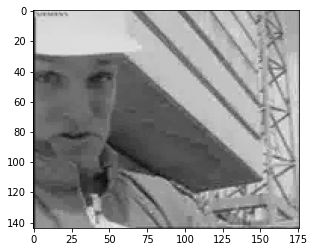

In [36]:
plt.figure()
plt.imshow(new_frame_179,cmap='gray')

In [37]:
PSNR(frame179, new_frame_179)

32.20405291720187

# three step search:

In [38]:
imsize = frame179.shape
new_frame_179 = np.zeros(imsize)
zero_coef_179 =0
num_of_intra =0
sad_total =0
for i in r_[:imsize[0]:4]:
    for j in r_[:imsize[1]:4]:
        block = frame179[i:(i+4),j:(j+4)]
        new_frame_179[i:(i+4),j:(j+4)] = block
        if (i!=0 and j!=0) :
            sad_motion,pred_motion,n_sad = thr_step_search(block,new_frame_178,4,i,j)
            sad_total = sad_total + n_sad
            pred_block_vertical = vertical_mode(new_frame_179,i,j)
            pred_block_horizontal = horizontal_mode(new_frame_179,i,j)
            pred_block_dc = dc_mode(new_frame_179,i,j)
            sad_vert = np.sum(np.abs(block - pred_block_vertical))
            
            sad_hor = np.sum(np.abs(block - pred_block_horizontal))
            sad_dc = np.sum(np.abs(block - pred_block_dc))
            sads= (sad_motion,sad_vert, sad_hor, sad_dc)
            blocks =(pred_motion,pred_block_vertical,pred_block_horizontal,pred_block_dc)
            
            index = np.argmin(sads) # position of min_sad in sads
            min_block = blocks[index]
            min_sad = sads[index]
            if (min_sad != sad_motion):
                num_of_intra = num_of_intra + 1
                
                
            dif_block = block - min_block
            dif_block = dct2(dif_block)
            qdct  = np.floor((dif_block + (40/2))/40)
            result = np.where(qdct==0)
            n_zeros = result[0].size
            zero_coef = zero_coef + n_zeros
        
            iqdct = qdct * 40
            iqdct = idct2(iqdct)
            new_frame_179[i:(i+4),j:(j+4)] = iqdct + min_block

In [39]:
print(f" Number of sad calculations is :{sad_total}") 
print(f" Number of zero coefficients is :{zero_coef}") 
print(f" Number of intra mode selection is :{num_of_intra}") 

 Number of sad calculations is :39689
 Number of zero coefficients is :91043
 Number of intra mode selection is :173


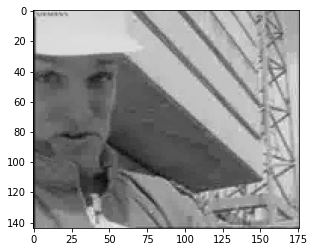

In [40]:
plt.figure()
plt.imshow(new_frame_179,cmap='gray')

In [43]:
PSNR(frame179, new_frame_179)

32.16725716147479

 # Αποτελέσματα
 Τα αναδημιουργημένα frame παρουσιάζονται παραπάνω όπως και τα αποτελέσματα. Εδώ είναι ένας πίνακας που περιέχει όλα τα αποτελέσματα συνολικά.

Results |Exhaustive search | 2d log search | three step search | intra prediction-frame178
:-------------------|:-------------------|:---------------:|--------------------:|--------------------:
**sad calculations**       | 411401    | 91664     | 39689       | 
**zero coeffictients**     | 44852     | 67976     | 91043       | 21424
**intra mode selection**   | 72        | 176       | 173         | 
**PSNR**                   | 32.633357 | 32.20405  | 32.1672571  | 31.872